## Electricity Demand Forecasting Integrating Solar Energy PV Generated and Weather Data Pipeline

#### Author: Alireza Maleki        
#### Date: 8/10/2024

#### Pipeline Sections are as follows:
    0- Task Overview
    1- Data Loading and Preprocessing
    2- Integrating Data
    3- Feature Engineering
    4- Exploratory Data Analysis
    5- Training Prediction Models: Linear Regression (Baseline) + XGBoost (Advanced Model) + Model Stability Investigation
    6- Uncertainty Forecasting with Quantile Regression (QR) using Statsmodels 
    7- Conclusion


## Electricity Demand Forecasting Integrating Solar Energy PV Generated and Weather Data Pipeline

#### Author: Alireza Maleki        
#### Date: 8/10/2024

#### Pipeline Sections are as follows:
    0- Task Overview
    1- Data Loading and Preprocessing
    2- Integrating Data
    3- Feature Engineering
    4- Exploratory Data Analysis
    5- Training Prediction Models: Linear Regression (Baseline) + XGBoost (Advanced Model) + Model Stability Investigation
    6- Uncertainty Forecasting with Quantile Regression (QR) using Statsmodels 
    7- Conclusion


### Task Overview:
We have provided data sets that we would like you to analyse. The objective of this exercise is to assess your analytical skills, ability to derive insights from data, and how effectively you can present your results.

What We Expect: 
1-	Data Analysis:  Perform a thorough analysis of the dataset provided. You may use any tools or programming languages of your choice (e.g., Python, R). - Your analysis should aim to uncover key insights and trends from the data. - You are free to apply any statistical models or visualizations that you think will best communicate the findings. 

2-	Deliverables: 
a.	Code: Please submit the full code you used for your analysis. 
b.	Presentation Pack: Create a short presentation (in PowerPoint, PDF, or a similar format) summarizing your key findings and insights. This presentation will be used in your interview.
c.	Interview Presentation: You will have 15 minutes during your interview to present your findings to the panel. Focus on the most critical insights and ensure that your presentation is clear, concise, and well-structured. 

3-	 Submission Instructions: Please send the following files in a zip folder: 
•	Your code (in a readable format such as `.py`, `.R`, or `.ipynb`). 
•	Your presentation slides (in PowerPoint, PDF, or similar). 


### About the Data sets:
-	Electricity Demand Data (synth_actual.csv): `region`, `mpe_date`, `mpe_hh`, `mpe_time`, `unit`, `demand`. Please note that demand here represents energy consumption (in MWH). mpe_hh here represents the half hour of day ranging from 1 to 48. 
-	Weather Data (synth_weather.csv): `region`, `mpe_time`, `observation_value`. Represents temperature values at different time points and observation_value represents Temperature in Celsius. 
-	PV Generation Data (synth_pv): This file contains PV generation. `region`, `mpe_date`, `mpe_time`, `PV`. Represents PV generation in MW.



### Questions:

- Question1

The `demand` column represents consumption, not actual demand. How would you convert consumption to actual demand, and why is this distinction important for analysis?
- Question 2

Perform exploratory data analysis (EDA) on the attached data sets and apply your data science skills to find out some interesting insights/pattern from the data.
- Question 3

Train a predictive model using the data provided. Explain the choice of model, preprocessing steps, Feature Engineering and any hyperparameters you chose to tune.
- Question 4

Describe how you would incorporate uncertainty into your demand forecast. What methods or models would you use to provide a range of likely outcomes rather than a point estimate?


### 1- Data Loading and Preprocessing

#### 1.1-Importing the requried packages

In [56]:
# importing the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm
# import pymc3 as pm
#import theano.tensor as tt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ModuleNotFoundError: No module named 'theano'

#### 1.2- Data Loading and Initial Data Inspection

In [2]:
# read data from csv data files
weather_df = pd.read_csv('synth_weather.csv')
pv_df = pd.read_csv('synth_pv.csv')
demand_df = pd.read_csv('synth_actual.csv')


In [3]:
#Display, check data type, and summary stats
display(weather_df.head())
print(weather_df.info())
print(weather_df.describe())

,region,mpe_time,observation_value
0,Anon,2022-05-23 12:00:00,17.63
1,Anon,2020-12-28 01:30:00,16.34
2,Anon,2021-04-12 23:30:00,9.90
3,Anon,2022-01-18 08:00:00,22.56
4,Anon,2022-01-18 08:30:00,19.38


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52752 entries, 0 to 52751
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   region             52752 non-null  object 
 1   mpe_time           52752 non-null  object 
 2   observation_value  52752 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.2+ MB
None
       observation_value
count       52752.000000
mean           16.250214
std             6.219502
min             0.210000
25%            11.500000
50%            16.300000
75%            20.590000
max            39.240000


In [4]:
# Display, check Data type and summary stats
display(demand_df.head())
print(demand_df.info())
print(demand_df.describe())


,region,mpe_date,mpe_hh,mpe_time,unit,demand
0,Anon,2022-01-31,22,2022-01-31 11:00:00,MWH,3840.01
1,Anon,2022-02-11,27,2022-02-11 13:30:00,MWH,4873.51
2,Anon,2022-02-21,4,2022-02-21 02:00:00,MWH,3283.09
3,Anon,2022-03-03,28,2022-03-03 14:00:00,MWH,4668.34
4,Anon,2022-03-14,19,2022-03-14 09:30:00,MWH,4412.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52511 entries, 0 to 52510
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   region    52511 non-null  object 
 1   mpe_date  52511 non-null  object 
 2   mpe_hh    52511 non-null  int64  
 3   mpe_time  52511 non-null  object 
 4   unit      52511 non-null  object 
 5   demand    52511 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 2.4+ MB
None
             mpe_hh        demand
count  52511.000000  52511.000000
mean      24.499552   3933.455343
std       13.853283    676.187450
min        1.000000   2405.090000
25%       12.500000   3426.775000
50%       24.000000   3913.740000
75%       36.000000   4374.840000
max       48.000000   7159.370000


In [5]:
#Display, chaeck data type, and summary stats
display(pv_df.head())
print(pv_df.info())
print(pv_df.describe())

,region,mpe_date,mpe_time,PV
0,Anon,2023-05-29,2023-05-29 11:00:00,2733.22
1,Anon,2020-12-28,2020-12-28 01:00:00,0.00
2,Anon,2023-05-29,2023-05-29 09:30:00,1345.73
3,Anon,2022-09-22,2022-09-22 07:00:00,200.21
4,Anon,2023-05-29,2023-05-29 14:30:00,1786.71


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52752 entries, 0 to 52751
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   region    52752 non-null  object 
 1   mpe_date  52752 non-null  object 
 2   mpe_time  52752 non-null  object 
 3   PV        52752 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.6+ MB
None
                 PV
count  52752.000000
mean     691.542651
std      972.064013
min        0.000000
25%        0.000000
50%        4.400000
75%     1306.290000
max     4435.340000


#### 1.3- Handlign the missing values!

In [6]:
# Check for missing values
print("Missing Values in Electricity Demand Data:")
print(demand_df.isnull().sum())

print("\nMissing Values in PV Generation Data:")
print(pv_df.isnull().sum())

print("\nMissing Values in Weather Data:")
print(weather_df.isnull().sum())

Missing Values in Electricity Demand Data:
region      0
mpe_date    0
mpe_hh      0
mpe_time    0
unit        0
demand      0
dtype: int64

Missing Values in PV Generation Data:
region      0
mpe_date    0
mpe_time    0
PV          0
dtype: int64

Missing Values in Weather Data:
region               0
mpe_time             0
observation_value    0
dtype: int64


#### 1.4- Converting date and time columns to datetime

In [7]:
# Converting 'mpe_time' to datetime (includes date and time)
demand_df['mpe_datetime'] = pd.to_datetime(demand_df['mpe_time'], dayfirst=True)

# dropping 'mpe_date' and 'mpe_time'
demand_df.drop(columns=['mpe_date', 'mpe_time'], inplace=True)

# Converting 'mpe_date' and 'mpe_time' to datetime in pv_df
pv_df['mpe_datetime'] = pd.to_datetime(pv_df['mpe_time'], dayfirst=True)

# dropping 'mpe_date' and 'mpe_time'
pv_df.drop(columns=['mpe_date', 'mpe_time'], inplace=True)


# Convert 'mpe_time' to datetime in weather_df 
weather_df['mpe_datetime'] = pd.to_datetime(weather_df['mpe_time'], dayfirst=True)

weather_df.drop(columns=['mpe_time'], inplace=True)

C:\Users\alima\AppData\Local\Temp\ipykernel_5640\1600379311.py:2: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  demand_df['mpe_datetime'] = pd.to_datetime(demand_df['mpe_time'], dayfirst=True)
C:\Users\alima\AppData\Local\Temp\ipykernel_5640\1600379311.py:8: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  pv_df['mpe_datetime'] = pd.to_datetime(pv_df['mpe_time'], dayfirst=True)
C:\Users\alima\AppData\Local\Temp\ipykernel_5640\1600379311.py:15: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  weather_df['mpe_datetime'] = pd.to_datetime(weather_df['mpe_time'], dayfirst=True)


#### 1.5- Checkign for duplicates

In [8]:
# Define unique identifiers for each DataFrame
demand_unique_cols = ['mpe_datetime']
pv_unique_cols = ['mpe_datetime']
weather_unique_cols = ['mpe_datetime']  # Note: Weather data doesn't have 'mpe_date'

# Function to check duplicates
def check_duplicates(df, unique_cols, df_name):
    duplicate_count = df.duplicated(subset=unique_cols).sum()
    if duplicate_count > 0:
        print(f"**{df_name}** has {duplicate_count} duplicate records based on {unique_cols}.")
        # Optionally, display duplicated rows
        duplicates = df[df.duplicated(subset=unique_cols, keep=False)]
        print(duplicates)
    else:
        print(f"**{df_name}** has no duplicate records based on {unique_cols}.")

# Check duplicates in each DataFrame
check_duplicates(demand_df, demand_unique_cols, 'Electricity Demand Data')
check_duplicates(pv_df, pv_unique_cols, 'PV Generation Data')
check_duplicates(weather_df, weather_unique_cols, 'Weather Data')

**Electricity Demand Data** has no duplicate records based on ['mpe_datetime'].
**PV Generation Data** has no duplicate records based on ['mpe_datetime'].
**Weather Data** has no duplicate records based on ['mpe_datetime'].


#### 1.6- Checking the unique values in the region column!

In [9]:
print(demand_df['region'].unique())
print(pv_df['region'].unique())
print(weather_df['region'].unique())

['Anon']
['Anon']
['Anon']


### 2- Integrating Data

#### 2.1- Merge Electricy demand and PV generation data frames

In [10]:
# Merge electricity demand and pv generation data frames on 'region', 'mpe_date', and 'mpe_time'
merged_df = pd.merge(demand_df, pv_df, on=['region', 'mpe_datetime'], how='left')

# Filling NaN PV values with 0 (if PV data is missing for certain intervals)
merged_df['PV'].fillna(0, inplace=True)

C:\Users\alima\AppData\Local\Temp\ipykernel_5640\1767670671.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['PV'].fillna(0, inplace=True)


#### 2.2- Merge with Weatehr data

In [11]:
# Merging on 'region' and 'mpe_time'
merged_df = pd.merge(merged_df, weather_df, on=['region', 'mpe_datetime'], how='left')

# Renaming 'observation_value' to 'Temperature_C'
merged_df.rename(columns={'observation_value': 'Temperature_C'}, inplace=True)

# Handle missing Temperature_C values with the mean temperature
merged_df['Temperature_C'].fillna(merged_df['Temperature_C'].mean(), inplace=True)

C:\Users\alima\AppData\Local\Temp\ipykernel_5640\159522734.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Temperature_C'].fillna(merged_df['Temperature_C'].mean(), inplace=True)


#### 2.3- Check duplicates for merged data

In [12]:
check_duplicates(merged_df, 'mpe_datetime', 'Merged DataFrame')

**Merged DataFrame** has no duplicate records based on mpe_datetime.


#### 2.4- Verifying Merges

In [13]:
print("Merged DataFrame Head:")
display(merged_df.head())

print("\nMerged DataFrame Info:")
print(merged_df.info())

Merged DataFrame Head:


,region,mpe_hh,unit,demand,mpe_datetime,PV,Temperature_C
0,Anon,22,MWH,3840.01,2022-01-31 11:00:00,1982.10,22.86
1,Anon,27,MWH,4873.51,2022-02-11 13:30:00,2708.16,27.01
2,Anon,4,MWH,3283.09,2022-02-21 02:00:00,0.00,18.19
3,Anon,28,MWH,4668.34,2022-03-03 14:00:00,822.35,22.45
4,Anon,19,MWH,4412.00,2022-03-14 09:30:00,1063.66,21.45



Merged DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52511 entries, 0 to 52510
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   region         52511 non-null  object        
 1   mpe_hh         52511 non-null  int64         
 2   unit           52511 non-null  object        
 3   demand         52511 non-null  float64       
 4   mpe_datetime   52511 non-null  datetime64[ns]
 5   PV             52511 non-null  float64       
 6   Temperature_C  52511 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 2.8+ MB
None


### 3-Feature Engineering

#### 3.1-convert consumption to demand and actual demand, and discussion about its importance!

#### Converting consumption to actual demand:

* Consumption:
    is the cumulative amount of electricity used over a period of time (in MWh).

* Actual Demand:
    Demand refers to the immediate rate at which the energy is used (in MW).
    
As the consumption is the total amount of energy consumed over a specific period of time, the demand will be calculated by dividing consumption over the period of time. Since the Meter Point Enumeration is Half_Hourly, in order to calculate the demand from consumption one needs to divide the consumption by 0.5(h);

    Energy (MWh) = Power (MW) x Time(Hours)
    
As a result:

    Demand(MW) = Consumption(MWh) / 0.5 

#### Why demand is importatn for analysis?

Demand as the immediate energy use provides insight into the major energy transformation issues and Demand forecasting is of crucial importance in the liberalized electricity markets. Examples of the imporatnt issues area  s foloows:

* Operational Planning and infrustructure sizing:
    Since demand is a measure of the immediate rate of energy consumption, it priveds insight into the grid status             which to ensure that the  load can meet the peak electricity demands without compromising grid reliability. This           also leads to the determinaiton of the generation capacity to meet the demand. 
    
           
* Energy Forecasting:
    Since the demand is the max power required to be available in the grid, it plays an essencial role in energy forecasitn     which is crucial to meet the demand and prevent blackouts.
    
    
#### Actual Demand:

In smart grids the integration of renewable energies including solar energy (PV-generated energy) includes fluctuations in the power supply. As a result, it is crucial to forecast the actual demand as the difference between the demand and the PV generated to ensure that power grids can operate reliably, safely, and stably.

This way actual demand is defined as : 

    Actual Demand = Demand(MW) - PV(MW)


    

#### 3.2- Converting consumption to demand

In [14]:
merged_df['demand_MW'] = merged_df['demand'] * 2

#### 3.3- Creating the actual demand as the difference between Demand and the generated PV power:

In [15]:
merged_df['actual_demand_MW'] = merged_df['demand_MW'] - merged_df['PV']

#### 3.4- Extracting Temporal Features

In [16]:
# Extracting hour, day of week, month from 'mpe_datetime'
merged_df['hour'] = merged_df['mpe_datetime'].dt.hour
merged_df['day_of_week'] = merged_df['mpe_datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
merged_df['month'] = merged_df['mpe_datetime'].dt.month

#### 3.5- Creating Categorical Features

In [17]:
# Whether the day is a weekend!
merged_df['is_weekend'] = merged_df['day_of_week'].apply(lambda x: 1 if x >=5 else 0)

### 4- Exploratory Data Analysis (EDA)

#### 4.1- Stats Summary

In [18]:
print("Descriptive Statistics for Demand:")
display(pd.DataFrame(merged_df[['demand', 'demand_MW', 'actual_demand_MW', 'PV', 'Temperature_C', 'hour']].describe()))


Descriptive Statistics for Demand:


,demand,demand_MW,actual_demand_MW,PV,Temperature_C,hour
count,52511.000000,52511.000000,52511.000000,52511.000000,52511.000000,52511.000000
mean,3933.455343,7866.910686,7174.059481,692.851205,16.228426,11.500219
std,676.187450,1352.374900,1239.887916,973.434699,6.222131,6.922136
min,2405.090000,4810.180000,3214.410000,0.000000,0.210000,0.000000
25%,3426.775000,6853.550000,6290.620000,0.000000,11.470000,6.000000
50%,3913.740000,7827.480000,7030.720000,4.320000,16.260000,12.000000
75%,4374.840000,8749.680000,7898.275000,1311.225000,20.570000,17.500000
max,7159.370000,14318.740000,13073.280000,4435.340000,39.240000,23.000000


#### 4.2- Distribution of Demand and Actual Demand

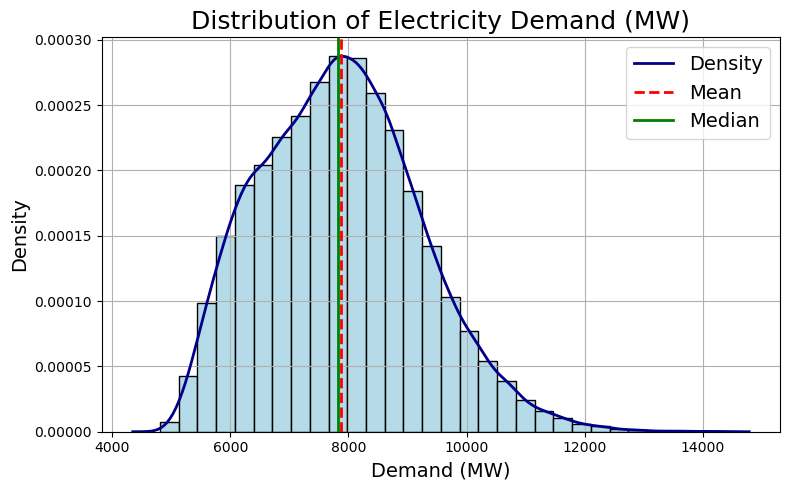

In [19]:
plt.figure(figsize=(8,5))
sns.kdeplot(merged_df['demand_MW'], color='darkblue', linewidth=2, label='Density')
sns.histplot(merged_df['demand_MW'], bins=30, kde=False, color='lightblue', stat='density', alpha=0.9)
plt.axvline(merged_df['demand_MW'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.axvline(merged_df['demand_MW'].median(), color='green', linestyle='-', linewidth=2, label='Median')
plt.title('Distribution of Electricity Demand (MW)', fontsize = 18)
plt.xlabel('Demand (MW)', fontsize=14)
plt.ylabel('Density', fontsize = 14)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('Histogram_of_Demand(MW)_2.jpg', format='jpg', dpi=300)
plt.show()

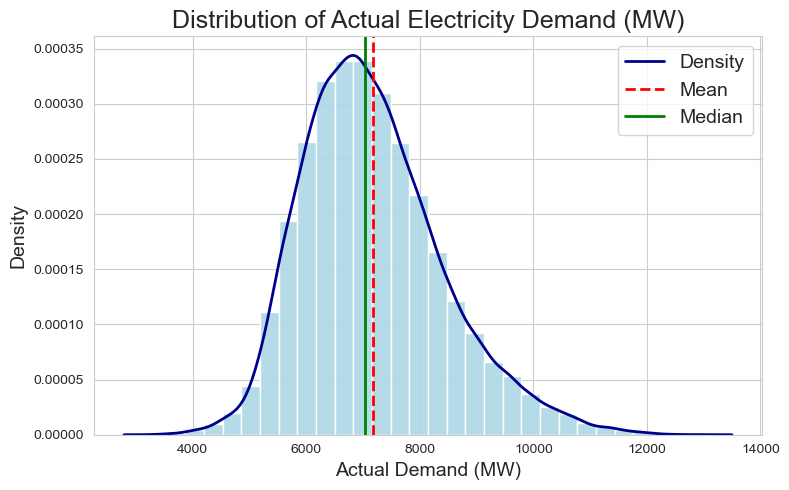

In [66]:
#distirbution of actual demand
plt.figure(figsize=(8,5))
sns.kdeplot(merged_df['actual_demand_MW'], color='darkblue', linewidth=2, label='Density')
sns.histplot(merged_df['actual_demand_MW'], bins=30, kde=False, color='lightblue', stat='density', alpha=0.9)
plt.axvline(merged_df['actual_demand_MW'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.axvline(merged_df['actual_demand_MW'].median(), color='green', linestyle='-', linewidth=2, label='Median')
plt.title('Distribution of Actual Electricity Demand (MW)', fontsize =18)
plt.xlabel('Actual Demand (MW)', fontsize = 14)
plt.ylabel('Density', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid(True)
plt.tight_layout()
plt.savefig('Histogram_of_Actual_Demand(MW)_2.jpg', format='jpg', dpi=300)
plt.show()

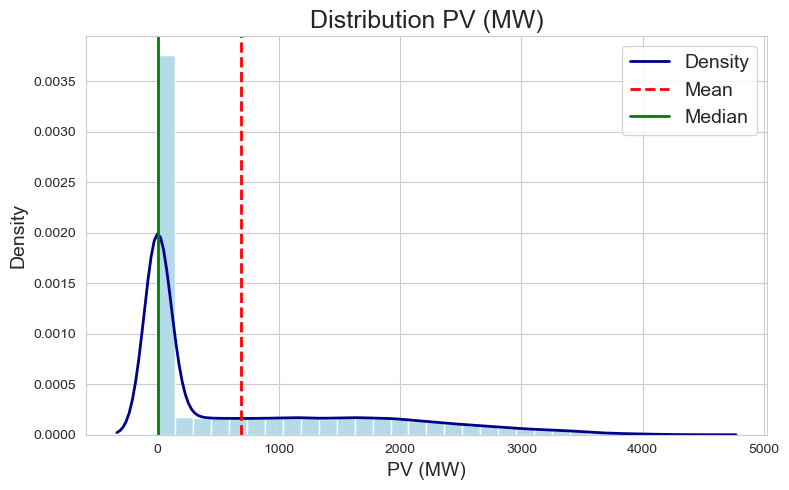

In [70]:
#distirbution of PV
plt.figure(figsize=(8,5))
sns.kdeplot(merged_df['PV'], color='darkblue', linewidth=2, label='Density')
sns.histplot(merged_df['PV'], bins=30, kde=False, color='lightblue', stat='density', alpha=0.9)
plt.axvline(merged_df['PV'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.axvline(merged_df['PV'].median(), color='green', linestyle='-', linewidth=2, label='Median')
plt.title('Distribution PV (MW)', fontsize =18)
plt.xlabel('PV (MW)', fontsize = 14)
plt.ylabel('Density', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid(True)
plt.tight_layout()
plt.savefig('Histogram_of_PV(MW)_2.jpg', format='jpg', dpi=300)
plt.show()

#### 4.3 Timeseries plots

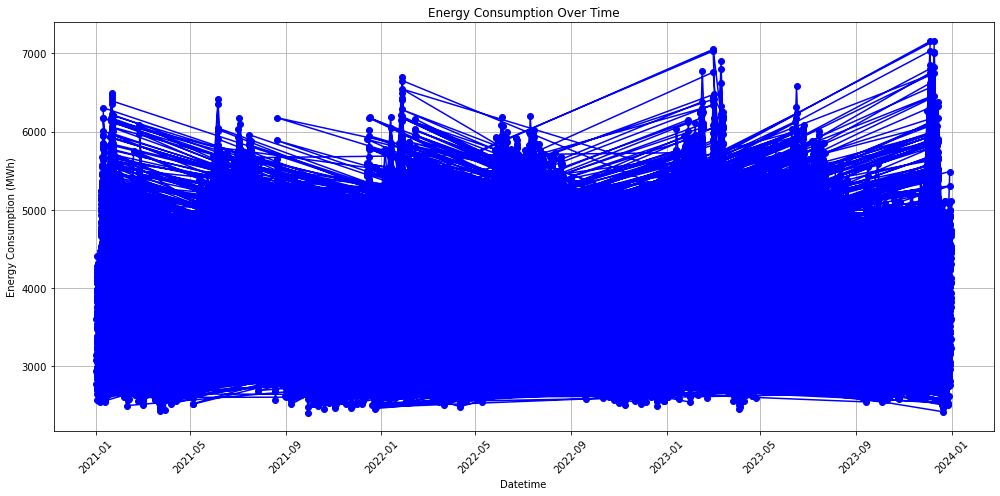

In [127]:
plt.figure(figsize=(12,6))
plt.plot(merged_df['mpe_datetime'], merged_df['demand_MW'], marker='o', linestyle='-', color='blue')
plt.title('Demand (MW) Over Time')
plt.xlabel('Datetime')
plt.ylabel('Demand (MW)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

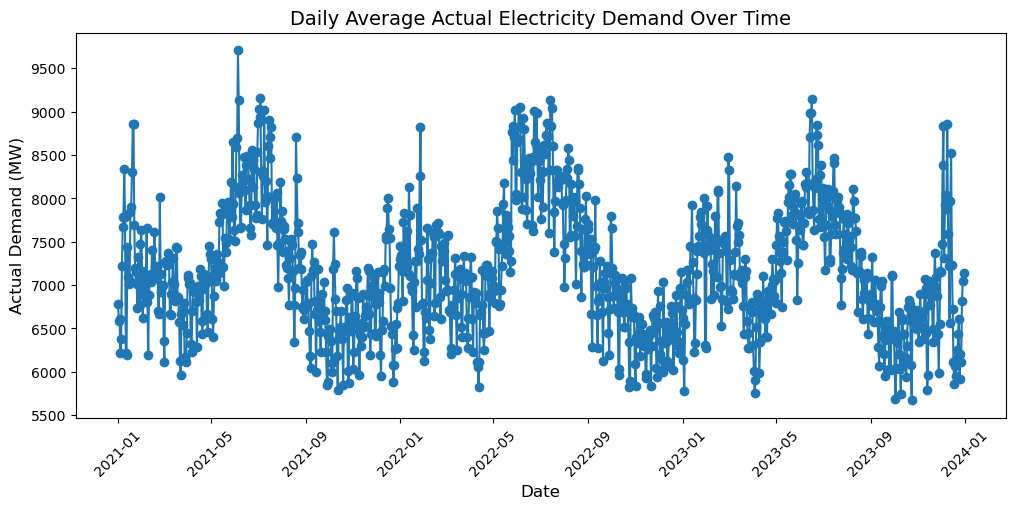

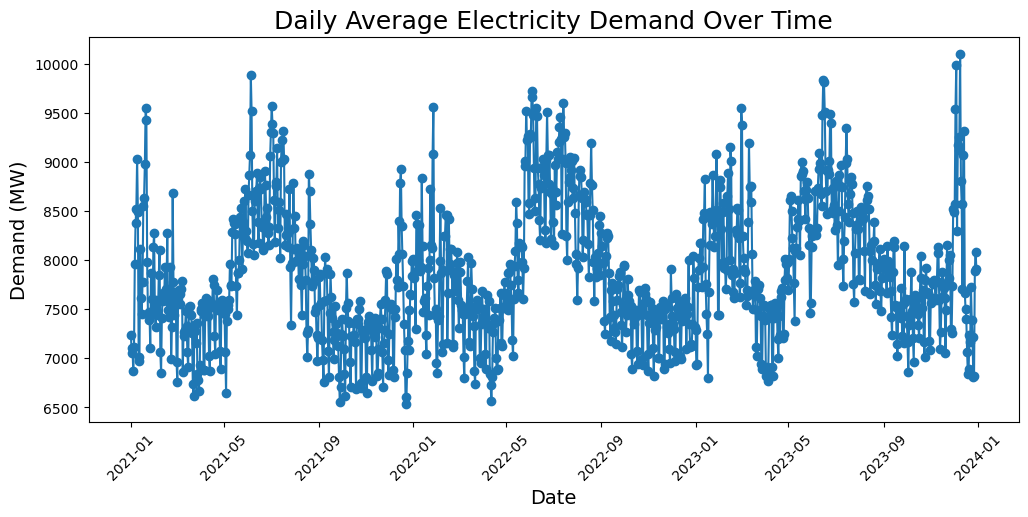

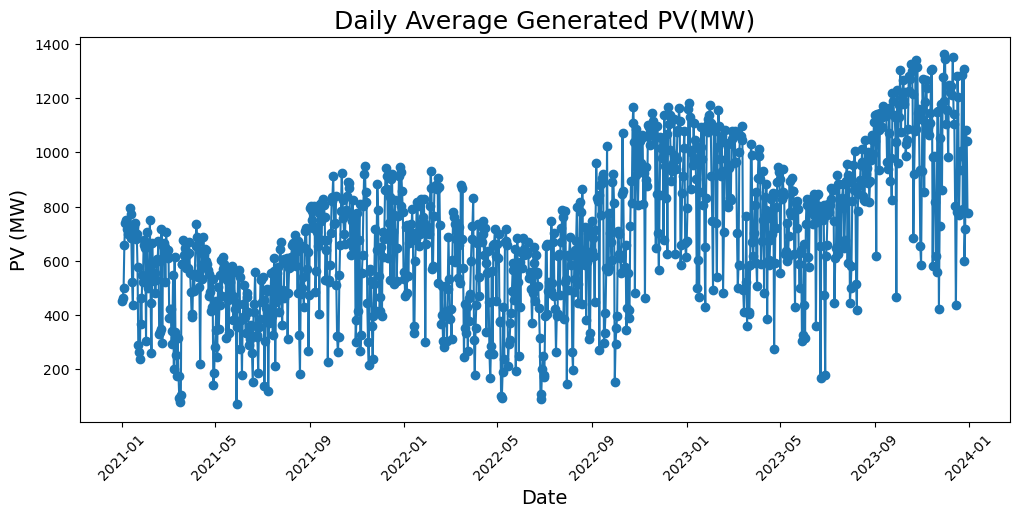

In [24]:
# aggregating to daily averages to improve the timeseris chart!
# Creating a new column for date only
merged_df['date'] = merged_df['mpe_datetime'].dt.date

# Aggregate to daily average
daily_df = merged_df.groupby('date').agg({
    'demand_MW': 'mean',
    'actual_demand_MW': 'mean',
    'PV': 'mean',
    'Temperature_C': 'mean'
}).reset_index()

# Plotting the time series for actual demand
plt.figure(figsize=(12,5))
plt.plot(pd.to_datetime(daily_df['date']), daily_df['actual_demand_MW'], marker='o', linestyle='-', label='Actual Demand')
plt.title('Daily Average Actual Electricity Demand Over Time', fontsize = 14)
plt.xlabel('Date', fontsize =12)
plt.ylabel('Actual Demand (MW)', fontsize =12)
plt.xticks(rotation=45)
# plt.savefig('daily_average_actual_demand_timeseries.jpg', format='jpg', dpi=300)
plt.show()

# plotting the time series for demand
plt.figure(figsize=(12,5))
plt.plot(pd.to_datetime(daily_df['date']), daily_df['demand_MW'], marker='o', linestyle='-', label='Demand')
plt.title('Daily Average Electricity Demand Over Time', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Demand (MW)', fontsize = 14)
plt.xticks(rotation=45)
# plt.savefig('daily_average_demand_timeseries.jpg', format='jpg', dpi=300)
plt.show()

# plotting the time series for demand
plt.figure(figsize=(12,5))
plt.plot(pd.to_datetime(daily_df['date']), daily_df['PV'], marker='o', linestyle='-', label='PV')
plt.title('Daily Average Generated PV(MW)', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('PV (MW)', fontsize = 14)
plt.xticks(rotation=45)
plt.savefig('daily_average_PV_timeseries.jpg', format='jpg', dpi=300)
plt.show()

#### 4.4-  Demand and Actual Demand by Day of week

C:\Users\alima\AppData\Local\Temp\ipykernel_8688\4009989099.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='day_of_week', y='demand', data=merged_df, palette='Set2')


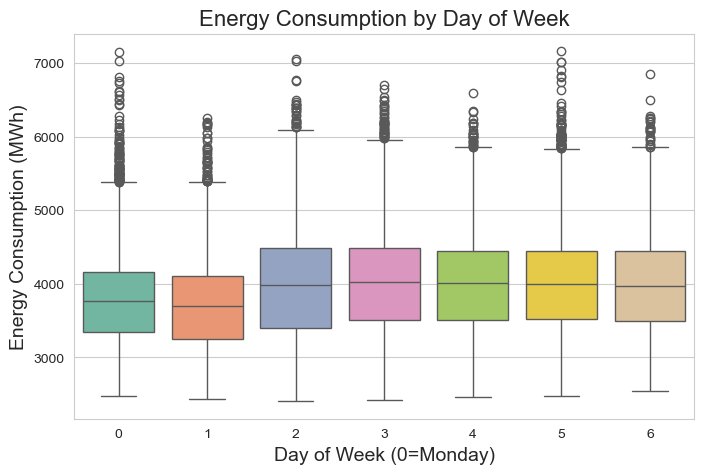

In [54]:
plt.figure(figsize=(8,5))
sns.boxplot(x='day_of_week', y='demand', data=merged_df, palette='Set2')
plt.title('Energy Consumption by Day of Week', fontsize=16)
plt.xlabel('Day of Week (0=Monday)', fontsize=14)
plt.ylabel('Energy Consumption (MWh)', fontsize=14)
plt.savefig('energy_consumption_dayofweek_boxplot_2.jpg', format='jpg', dpi=300)
plt.show()

C:\Users\alima\AppData\Local\Temp\ipykernel_8688\2048615031.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='day_of_week', y='actual_demand_MW', data=merged_df, palette='Set2')


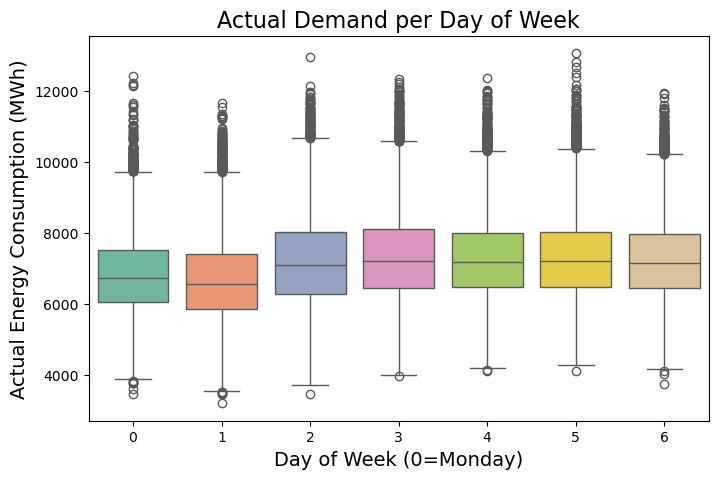

In [26]:
plt.figure(figsize=(8,5))
sns.boxplot(x='day_of_week', y='actual_demand_MW', data=merged_df, palette='Set2')
plt.title('Actual Demand per Day of Week', fontsize=16)
plt.xlabel('Day of Week (0=Monday)', fontsize=14)
plt.ylabel('Actual Energy Consumption (MWh)', fontsize=14)
plt.savefig('actual_demand_dayofweek_boxplot.jpg', format='jpg', dpi=300)
plt.show()

#### 4.5- Demand and Actual Demand by Hour of Day

C:\Users\alima\AppData\Local\Temp\ipykernel_8688\4225655862.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y='demand', data=merged_df, palette='Set3')


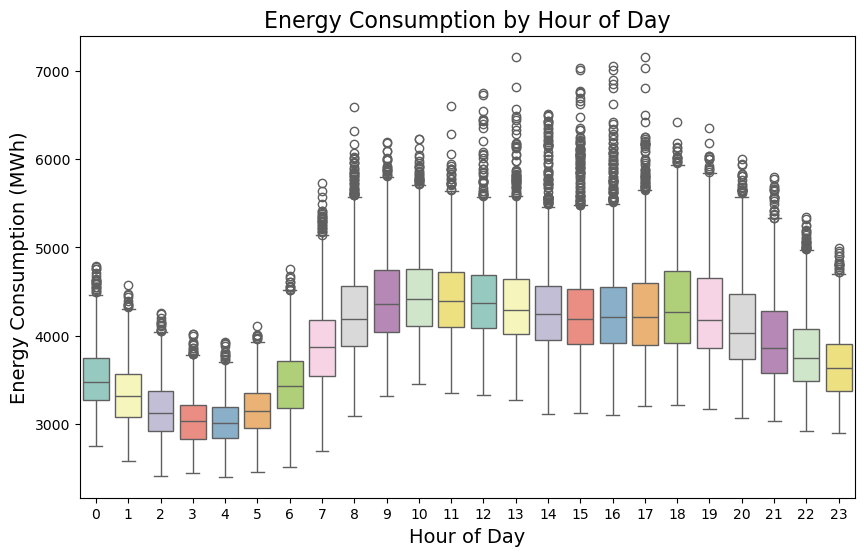

In [27]:
plt.figure(figsize=(10,6))
sns.boxplot(x='hour', y='demand', data=merged_df, palette='Set3')
plt.title('Energy Consumption by Hour of Day', fontsize =16)
plt.xlabel('Hour of Day', fontsize =14)
plt.ylabel('Energy Consumption (MWh)', fontsize =14)
plt.savefig('demand_hourofday_boxplot.jpg', format='jpg', dpi=300)
plt.show()

C:\Users\alima\AppData\Local\Temp\ipykernel_8688\3810031830.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y='actual_demand_MW', data=merged_df, palette='Set3')


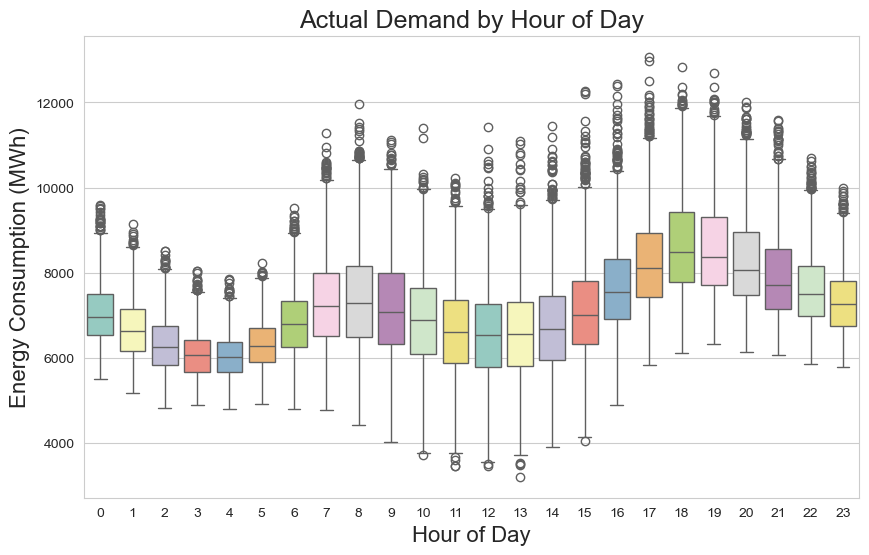

In [73]:
# plotting boxplot for actual demand
plt.figure(figsize=(10,6))
sns.boxplot(x='hour', y='actual_demand_MW', data=merged_df, palette='Set3')
plt.title('Actual Demand by Hour of Day', fontsize=18)
plt.xlabel('Hour of Day', fontsize=16)
plt.ylabel('Energy Consumption (MWh)', fontsize=16)
# plt.savefig('actual_demand_hourofday_boxplot_2.jpg', format='jpg', dpi=300)
plt.show()

#### 4.6- Correlaiton Matrix

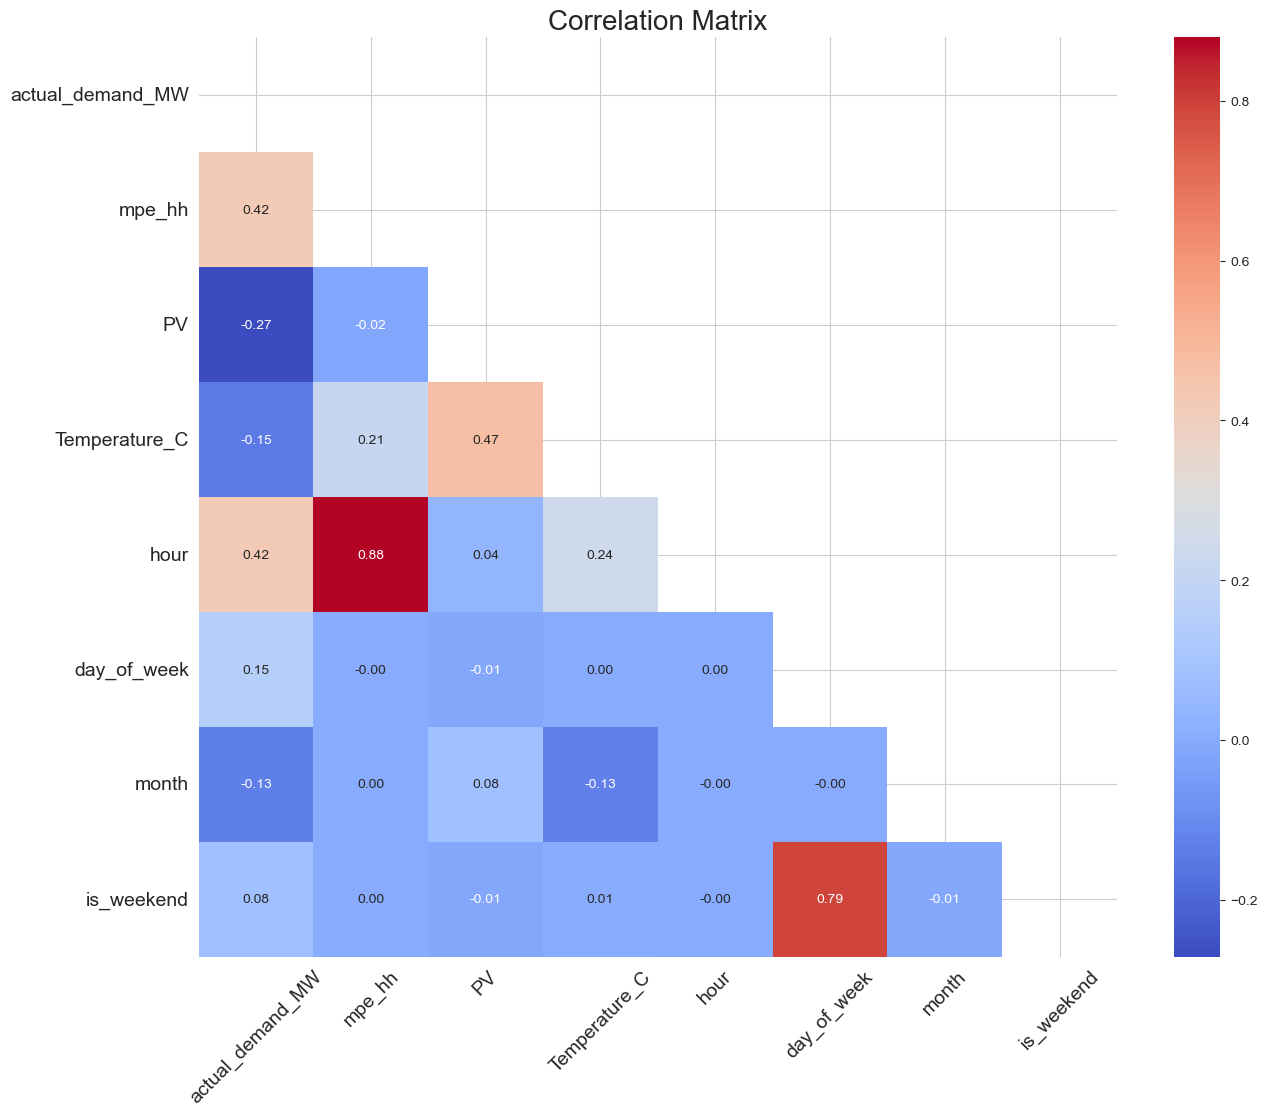

In [58]:
plt.figure(figsize=(12,10))

corr = merged_df[['actual_demand_MW', 'mpe_hh', 'PV', 'Temperature_C', 'hour', 'day_of_week', 'month', 'is_weekend']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 10})
plt.title('Correlation Matrix', fontsize = 20)
plt.tight_layout()
plt.xticks(fontsize=14, rotation=45)  
plt.yticks(fontsize=14, rotation=0)
plt.savefig('Correlation_Matrix.jpg', format='jpg', dpi=300)
plt.show()

#### 4.7- Actual Demand against Temperature

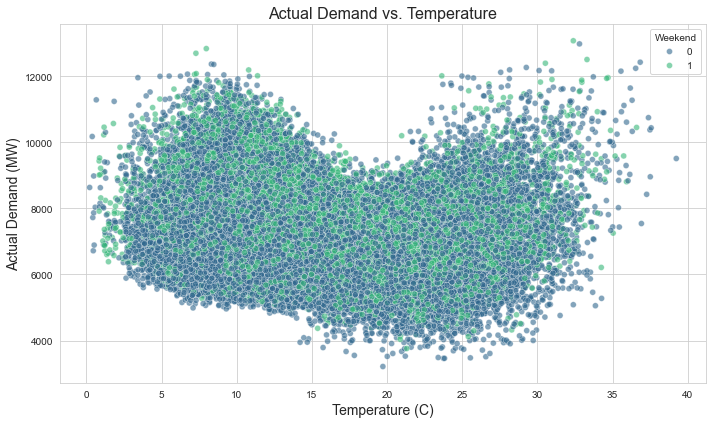

In [150]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='Temperature_C', 
    y='actual_demand_MW', 
    hue='is_weekend', 
    palette='viridis', 
    alpha=0.6,
    data=merged_df 
)
plt.title('Actual Demand vs. Temperature', fontsize = 16)
plt.xlabel('Temperature (C)', fontsize=14)
plt.ylabel('Actual Demand (MW)', fontsize=14)
plt.legend(title='Weekend')
plt.grid(True)
plt.tight_layout()
plt.savefig('Actual_Demand_vs_Temperature.jpg', format='jpg', dpi=300)
plt.show()

#### 4.8- Demand against PV

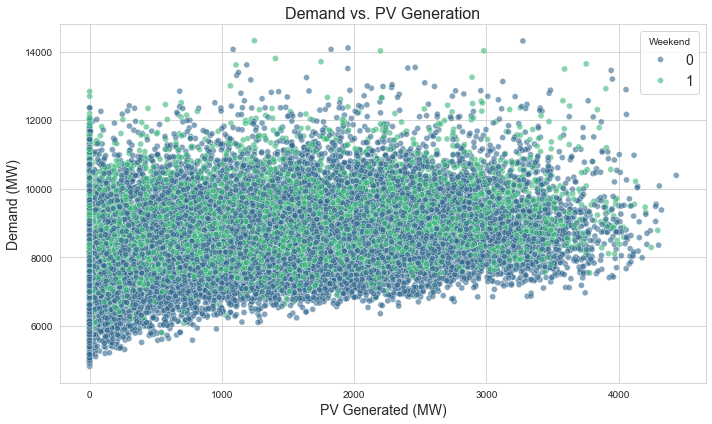

In [160]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='PV', 
    y='demand_MW', 
    hue='is_weekend', 
    palette='viridis', 
    alpha=0.6,
    data=merged_df 
)
plt.title('Demand vs. PV Generation', fontsize=16)
plt.xlabel('PV Generated (MW)', fontsize=14)
plt.ylabel('Demand (MW)', fontsize = 14)
plt.legend(title='Weekend', fontsize = 14)
plt.grid(True)
plt.tight_layout()
plt.savefig('Demand_vs_PV_Generation.jpg', format='jpg', dpi=300)
plt.show()

#### 4.8- Daily Average PV against Daily Average Temperature 

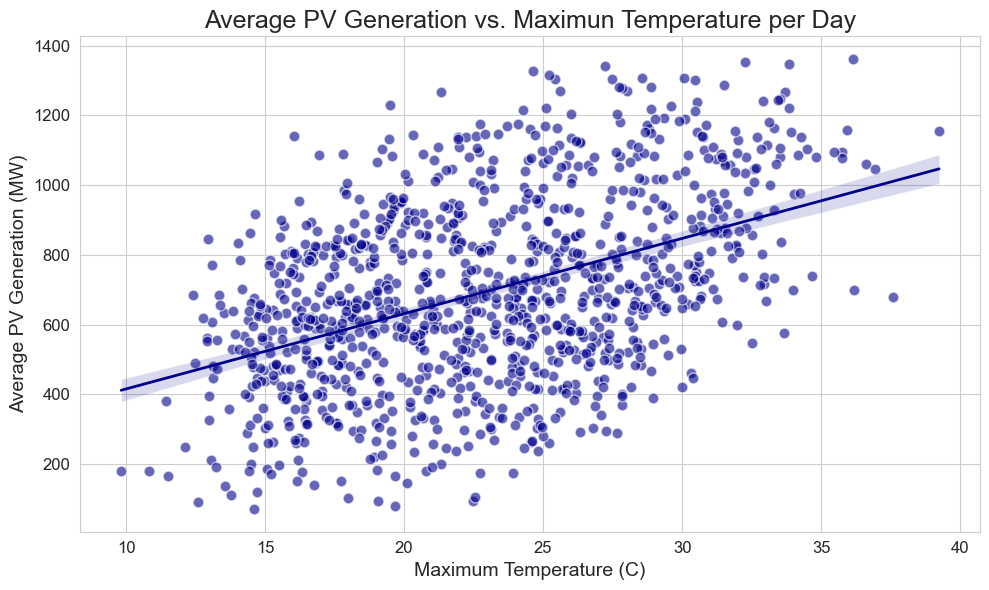

In [25]:
#Aggregating data to calculate the average PV generation and average temperature per day
daily_agg = merged_df.groupby('date').agg({
    'PV': 'mean',
    'Temperature_C': 'max'
}).reset_index()

sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.regplot(
    x='Temperature_C',
    y='PV',
    data=daily_agg,
    scatter_kws={
        'color': 'darkblue',
        's': 60,                
        'alpha': 0.6,           
        'edgecolor': 'w'        
    },
    line_kws={
        'color': 'darkblue', 
        'linewidth': 2          
    }
)

plt.title('Average PV Generation vs. Maximun Temperature per Day', fontsize=18)
plt.xlabel('Maximum Temperature (C)', fontsize=14)
plt.ylabel('Average PV Generation (MW)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
# plt.savefig('maximum_pv_vs_max_temperature_per_day.jpg', format='jpg', dpi=300)
plt.show()

### 5- ML Predictive Models

#### 5.1- Defining feature columsn and target column:
Since actual demand is taken as the net demand after considering the PV integration, it's selected as the target variable. 
Also since "mpe_hh" feature (half hourly) has a very high correlation with "hour" feature with actual demand and both have the same
correlation with "actual_demand" only "hour" is taken as one of the predictors. 

In [26]:
# definign regressors
feature_cols = [
    'PV', 
    'Temperature_C', 
    'hour', 
    'day_of_week', 
    'month', 
    'is_weekend'
]

# Defining target variable
target = 'actual_demand_MW'

# Separate features and target
X = merged_df[feature_cols]
y = merged_df[target]

#### 5.2- Splitting Data into Trainign and Testing Sets, following the chronological order!

In [27]:
# Sorting the DataFrame by 'mpe_datetime' to ensure chronological order
merged_df.sort_values('mpe_datetime', inplace=True)

# splitting data:  80% training, 20% testing
split_index = int(len(merged_df) * 0.8)

# Split the features and target
X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

print(f"Training Set Shape: {X_train.shape}")
print(f"Testing Set Shape: {X_test.shape}\n")

Training Set Shape: (42008, 6)
Testing Set Shape: (10503, 6)



#### 5.3-  Training Linear Regression Model as the Baseline Model!

In [28]:
# Instantiating the Linear Regression model
lr_model = LinearRegression()

# Training the model
lr_model.fit(X_train, y_train)

# Predicting on the test set
y_pred_lr = lr_model.predict(X_test)

# Evaluating the model
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print(f"Mean Absolute Error (MAE): {mae_lr:.2f} MW")
print(f"Root Mean Squared Error (RMSE): {rmse_lr:.2f} MW")
print(f"R-squared (R²): {r2_lr:.2f}")

Linear Regression Performance:
Mean Absolute Error (MAE): 790.02 MW
Root Mean Squared Error (RMSE): 1021.03 MW
R-squared (R²): 0.20


C:\Users\alima\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### 5.4- Training Advanced Model : XGBoost

In [29]:
# Initializing the XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

# Training the model
xgb_model.fit(X_train, y_train)

# Predicting on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluating the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MAE: {mae_xgb:.2f}")
print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"XGBoost R²: {r2_xgb:.2f}")

XGBoost MAE: 484.20
XGBoost RMSE: 619.96
XGBoost R²: 0.71


C:\Users\alima\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### 5.5- Hyper Parameter Tuning using GridsearchCV

In [30]:
# parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initializing GridSearchCV with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
grid_search_xgb = GridSearchCV(
    estimator=xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42
    ),
    param_grid=param_grid_xgb,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search_xgb.fit(X_train, y_train)

# Best parameters
print("\nBest Parameters from GridSearchCV for XGBoost:")
print(grid_search_xgb.best_params_)

# Best estimator
best_xgb_model = grid_search_xgb.best_estimator_

# Prediction on the test set with the best model!
y_pred_best_xgb = best_xgb_model.predict(X_test)

# Evaluation
mae_best_xgb = mean_absolute_error(y_test, y_pred_best_xgb)
rmse_best_xgb = mean_squared_error(y_test, y_pred_best_xgb, squared=False)
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)

print("\nBest XGBoost Regressor Performance:")
print(f"Mean Absolute Error (MAE): {mae_best_xgb:.2f} MW")
print(f"Root Mean Squared Error (RMSE): {rmse_best_xgb:.2f} MW")
print(f"R-squared (R²): {r2_best_xgb:.2f}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Best Parameters from GridSearchCV for XGBoost:
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.7}

Best XGBoost Regressor Performance:
Mean Absolute Error (MAE): 480.00 MW
Root Mean Squared Error (RMSE): 612.31 MW
R-squared (R²): 0.71


C:\Users\alima\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### 5.6- Model Evaluation

In [31]:
# Compare MAE and RMSE
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'XGBoost'],
    'MAE': [mae_lr, mae_best_xgb],
    'RMSE': [rmse_lr, rmse_best_xgb],
    'r2': [r2_lr, r2_best_xgb]
})

print(comparison)

               Model         MAE         RMSE        r2
0  Linear Regression  790.023474  1021.029304  0.200700
1            XGBoost  479.997223   612.314992  0.712536


#### 5.7- Feature Importance by XGBoost

<Figure size 1200x800 with 0 Axes>

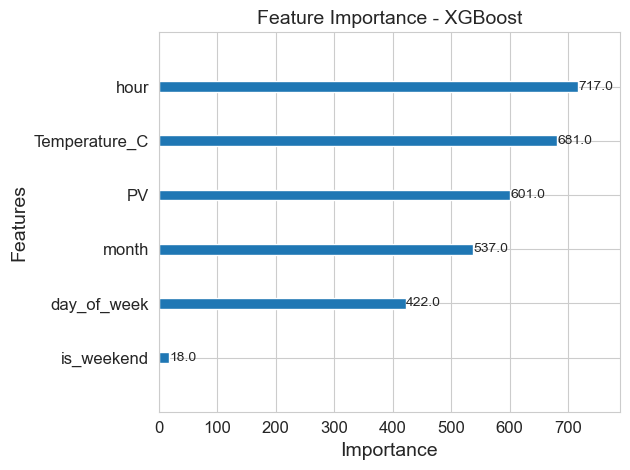

In [52]:
plt.figure(figsize=(12,8))
xgb.plot_importance(best_xgb_model, max_num_features=7, importance_type='weight')

#customizing the easthetics of the chart!
plt.title('Feature Importance - XGBoost', fontsize = 14)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig('feature_importance_xgboost_2.png', dpi=300)
plt.show()

#### 5.8- Model Stability

In [32]:
# Now use this best_xgb_model for further evaluations like TimeSeriesSplit stability testing
tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists to store the performance metrics
mae_list = []
rmse_list = []
r2_list = []

# Loop over each time series split
for train_index, test_index in tscv.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Train the model on each split using the best estimator
    best_xgb_model.fit(X_train_fold, y_train_fold)
    
    # Predict on the test fold
    y_pred_fold = best_xgb_model.predict(X_test_fold)
    
    # Calculate evaluation metrics
    mae_fold = mean_absolute_error(y_test_fold, y_pred_fold)
    rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    r2_fold = r2_score(y_test_fold, y_pred_fold)
    
    # Store the metrics
    mae_list.append(mae_fold)
    rmse_list.append(rmse_fold)
    r2_list.append(r2_fold)

# Print the results for each split
for i, (mae, rmse, r2) in enumerate(zip(mae_list, rmse_list, r2_list)):
    print(f"Fold {i+1} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

Fold 1 - MAE: 509.31, RMSE: 651.81, R²: 0.77
Fold 2 - MAE: 491.71, RMSE: 610.86, R²: 0.77
Fold 3 - MAE: 484.53, RMSE: 610.43, R²: 0.79
Fold 4 - MAE: 463.15, RMSE: 591.82, R²: 0.67
Fold 5 - MAE: 492.83, RMSE: 626.79, R²: 0.74


#### 5.9- Model Stability visualised!

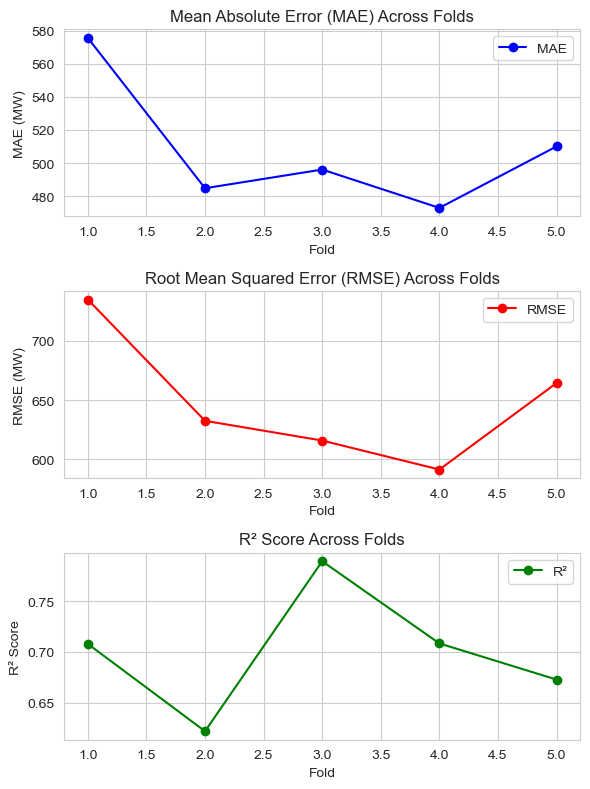

In [53]:
# Number of folds (based on tscv splits)
folds = range(1, len(mae_list) + 1)

# subplots for MAE, RMSE, and R²
fig, ax = plt.subplots(3, 1, figsize=(6, 8))

# MAE plot for each fold
ax[0].plot(folds, mae_list, marker='o', color='b', label='MAE')
ax[0].set_title('Mean Absolute Error (MAE) Across Folds')
ax[0].set_xlabel('Fold')
ax[0].set_ylabel('MAE (MW)')
ax[0].legend()
ax[0].grid(True)

# RMSE plot for each fold
ax[1].plot(folds, rmse_list, marker='o', color='r', label='RMSE')
ax[1].set_title('Root Mean Squared Error (RMSE) Across Folds')
ax[1].set_xlabel('Fold')
ax[1].set_ylabel('RMSE (MW)')
ax[1].legend()
ax[1].grid(True)

# R² plot for each fold
ax[2].plot(folds, r2_list, marker='o', color='g', label='R²')
ax[2].set_title('R² Score Across Folds')
ax[2].set_xlabel('Fold')
ax[2].set_ylabel('R² Score')
ax[2].legend()
ax[2].grid(True)

# Adjusting the layout
plt.tight_layout()
plt.show()

In [ ]:
#### 5.10-Adding lag features!

In [37]:
lags = [1, 2, 3]

# Add lag features for 'PV'
for lag in lags:
    merged_df[f'PV_lag_{lag}'] = merged_df['PV'].shift(lag)

# Add lag features for 'Temperature_C'
for lag in lags:
    merged_df[f'Temperature_lag_{lag}'] = merged_df['Temperature_C'].shift(lag)

# Drop any rows with NaN values caused by shifting
merged_df.dropna(inplace=True)
display(merged_df.head())

,region,mpe_hh,unit,demand,mpe_datetime,PV,Temperature_C,demand_MW,actual_demand_MW,hour,...,date,demand_lag_1,demand_lag_2,demand_lag_3,PV_lag_1,PV_lag_2,PV_lag_3,Temperature_lag_1,Temperature_lag_2,Temperature_lag_3
12083,Anon,13,MWH,3048.52,2021-01-01 06:30:00,182.65,20.68,6097.04,5914.39,6,...,2021-01-01,2891.04,2971.00,3256.47,72.85,3.30,0.00,17.44,17.49,16.63
13397,Anon,14,MWH,3386.87,2021-01-01 07:00:00,343.58,18.64,6773.74,6430.16,7,...,2021-01-01,3048.52,2891.04,2971.00,182.65,72.85,3.30,20.68,17.44,17.49
14711,Anon,15,MWH,3304.43,2021-01-01 07:30:00,509.17,19.17,6608.86,6099.69,7,...,2021-01-01,3386.87,3048.52,2891.04,343.58,182.65,72.85,18.64,20.68,17.44
16024,Anon,16,MWH,3965.65,2021-01-01 08:00:00,605.86,22.20,7931.30,7325.44,8,...,2021-01-01,3304.43,3386.87,3048.52,509.17,343.58,182.65,19.17,18.64,20.68
17337,Anon,17,MWH,4088.54,2021-01-01 08:30:00,918.28,19.50,8177.08,7258.80,8,...,2021-01-01,3965.65,3304.43,3386.87,605.86,509.17,343.58,22.20,19.17,18.64


In [45]:
feature_cols = [
    'PV', 
    'Temperature_C', 
    'hour', 
    'day_of_week', 
    'month', 
    'is_weekend', 
    'PV_lag_1', 'PV_lag_2', 'PV_lag_3', 
    'Temperature_lag_1', 'Temperature_lag_2', 'Temperature_lag_3'
]

# X contains the features for training
X = merged_df[feature_cols]

# y contains the target variable (e.g., actual demand)
y = merged_df['actual_demand_MW']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


#### 5.11- Fitting the linear regression model as the baseline model!

In [46]:
# Instantiating the Linear Regression model
lr_model = LinearRegression()

# Training the model
lr_model.fit(X_train, y_train)

# Predicting on the test set
y_pred_lr = lr_model.predict(X_test)

# Evaluating the model
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print(f"Mean Absolute Error (MAE): {mae_lr:.2f} MW")
print(f"Root Mean Squared Error (RMSE): {rmse_lr:.2f} MW")
print(f"R-squared (R²): {r2_lr:.2f}")

Linear Regression Performance:
Mean Absolute Error (MAE): 798.32 MW
Root Mean Squared Error (RMSE): 1051.36 MW
R-squared (R²): 0.37


C:\Users\alima\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### 5.12- XGBoost best_model adding lag features!

In [47]:
# parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initializing GridSearchCV with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
grid_search_xgb = GridSearchCV(
    estimator=xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42
    ),
    param_grid=param_grid_xgb,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search_xgb.fit(X_train, y_train)

# Best parameters
print("\nBest Parameters from GridSearchCV for XGBoost:")
print(grid_search_xgb.best_params_)

# Best estimator
best_xgb_model = grid_search_xgb.best_estimator_

# Prediction on the test set with the best model!
y_pred_best_xgb = best_xgb_model.predict(X_test)

# Evaluation
mae_best_xgb = mean_absolute_error(y_test, y_pred_best_xgb)
rmse_best_xgb = mean_squared_error(y_test, y_pred_best_xgb, squared=False)
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)

print("\nBest XGBoost Regressor Performance:")
print(f"Mean Absolute Error (MAE): {mae_best_xgb:.2f} MW")
print(f"Root Mean Squared Error (RMSE): {rmse_best_xgb:.2f} MW")
print(f"R-squared (R²): {r2_best_xgb:.2f}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Best Parameters from GridSearchCV for XGBoost:
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.9}

Best XGBoost Regressor Performance:
Mean Absolute Error (MAE): 491.02 MW
Root Mean Squared Error (RMSE): 633.50 MW
R-squared (R²): 0.77


C:\Users\alima\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [48]:
# Compare MAE and RMSE
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'XGBoost'],
    'MAE': [mae_lr, mae_best_xgb],
    'RMSE': [rmse_lr, rmse_best_xgb],
    'r2': [r2_lr, r2_best_xgb]
})

print(comparison)

               Model         MAE         RMSE        r2
0  Linear Regression  798.322670  1051.362474  0.369852
1            XGBoost  491.017351   633.504687  0.771210


#### 5.13- Feature importance including lag-features

<Figure size 1200x800 with 0 Axes>

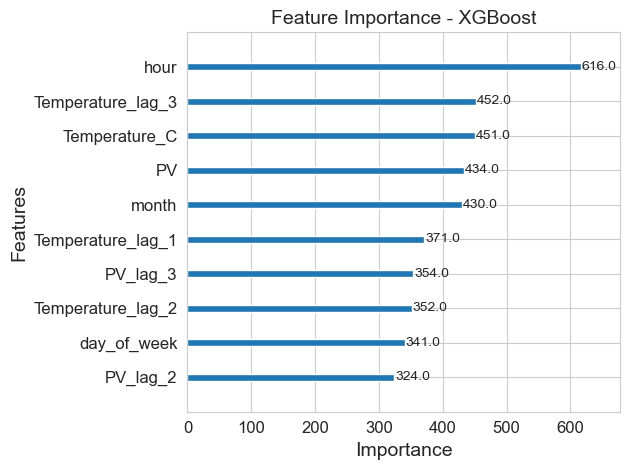

In [52]:
plt.figure(figsize=(12,8))
xgb.plot_importance(best_xgb_model, max_num_features=10, importance_type='weight')

#customizing the easthetics of the chart!
plt.title('Feature Importance - XGBoost', fontsize = 14)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig('feature_importance_xgboost_2.png', dpi=300)
plt.show()

#### 5.14- Investigating the stability of the model after adding lag-features

In [50]:
# Now use this best_xgb_model for further evaluations like TimeSeriesSplit stability testing
tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists to store the performance metrics
mae_list = []
rmse_list = []
r2_list = []

# Loop over each time series split
for train_index, test_index in tscv.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Train the model on each split using the best estimator
    best_xgb_model.fit(X_train_fold, y_train_fold)
    
    # Predict on the test fold
    y_pred_fold = best_xgb_model.predict(X_test_fold)
    
    # Calculate evaluation metrics
    mae_fold = mean_absolute_error(y_test_fold, y_pred_fold)
    rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    r2_fold = r2_score(y_test_fold, y_pred_fold)
    
    # Store the metrics
    mae_list.append(mae_fold)
    rmse_list.append(rmse_fold)
    r2_list.append(r2_fold)

# Print the results for each split
for i, (mae, rmse, r2) in enumerate(zip(mae_list, rmse_list, r2_list)):
    print(f"Fold {i+1} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

Fold 1 - MAE: 575.77, RMSE: 734.75, R²: 0.71
Fold 2 - MAE: 484.73, RMSE: 632.50, R²: 0.62
Fold 3 - MAE: 496.04, RMSE: 615.85, R²: 0.79
Fold 4 - MAE: 472.82, RMSE: 591.38, R²: 0.71
Fold 5 - MAE: 510.05, RMSE: 664.38, R²: 0.67


### Model Stability Visualisaiton

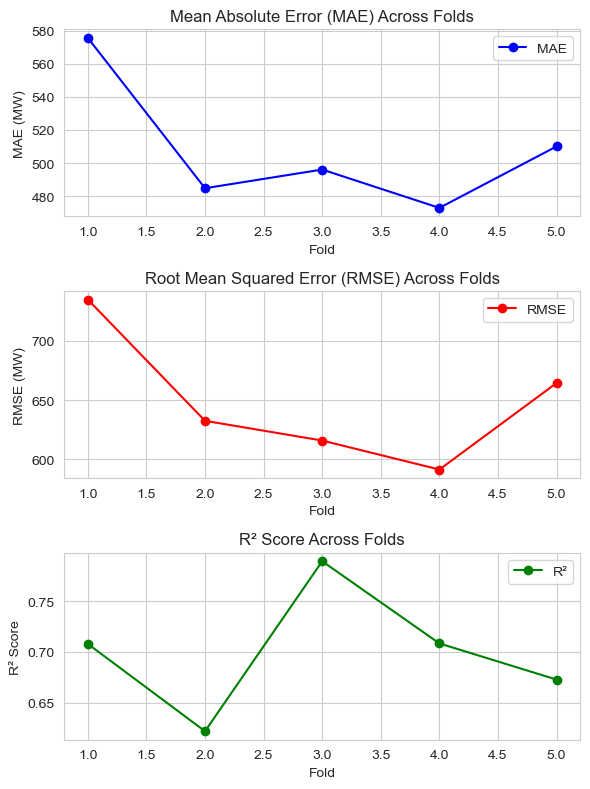

In [54]:
# Number of folds (based on tscv splits)
folds = range(1, len(mae_list) + 1)

# subplots for MAE, RMSE, and R²
fig, ax = plt.subplots(3, 1, figsize=(6, 8))

# MAE plot for each fold
ax[0].plot(folds, mae_list, marker='o', color='b', label='MAE')
ax[0].set_title('Mean Absolute Error (MAE) Across Folds')
ax[0].set_xlabel('Fold')
ax[0].set_ylabel('MAE (MW)')
ax[0].legend()
ax[0].grid(True)

# RMSE plot for each fold
ax[1].plot(folds, rmse_list, marker='o', color='r', label='RMSE')
ax[1].set_title('Root Mean Squared Error (RMSE) Across Folds')
ax[1].set_xlabel('Fold')
ax[1].set_ylabel('RMSE (MW)')
ax[1].legend()
ax[1].grid(True)

# R² plot for each fold
ax[2].plot(folds, r2_list, marker='o', color='g', label='R²')
ax[2].set_title('R² Score Across Folds')
ax[2].set_xlabel('Fold')
ax[2].set_ylabel('R² Score')
ax[2].legend()
ax[2].grid(True)

# Adjusting the layout
plt.tight_layout()
plt.show()

### 6- Uncertainty Forecasting with Quantile Regression (QR) using Statsmodels 

#### 6.1- Calculating Quantiles

In [74]:
# Adding a constant term for intercept
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Defining quantiles
quantiles = [0.05, 0.5, 0.95]
quantile_predictions = {}

for q in quantiles:
    print(f"\nTraining Quantile Regression for Quantile: {q}")
    quant_reg = sm.QuantReg(y_train, X_train_sm)
    res = quant_reg.fit(q=q)
    print(res.summary())
    # Predict on test set
    preds = res.predict(X_test_sm)
    quantile_predictions[q] = preds


Training Quantile Regression for Quantile: 0.05
                         QuantReg Regression Results                          
Dep. Variable:       actual_demand_MW   Pseudo R-squared:               0.2256
Model:                       QuantReg   Bandwidth:                       119.7
Method:                 Least Squares   Sparsity:                        5882.
Date:                Wed, 09 Oct 2024   No. Observations:                42008
Time:                        07:30:48   Df Residuals:                    42001
                                        Df Model:                            6
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5513.5487     24.844    221.925      0.000    5464.854    5562.244
PV               -0.3366      0.009    -38.427      0.000      -0.354      -0.319
Temperature_C   -21.4063      0.844    -25.355      0.000     -23.061 

C:\Users\alima\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


In [43]:
# Creating a DataFrame for prediction intervals
prediction_intervals = pd.DataFrame({
    'Lower': quantile_predictions[0.05],
    'Median': quantile_predictions[0.5],
    'Upper': quantile_predictions[0.95]
})

# Displaying the first few prediction intervals
print("\nPrediction Intervals:")
print(prediction_intervals.head())


Prediction Intervals:
             Lower       Median        Upper
42008  5097.059492  6505.714528  8542.596834
42009  6139.257369  7412.456271  9517.328362
42010  5492.545663  6843.008953  8877.401516
42011  6241.793528  7643.673573  9844.265955
42012  6408.767415  7735.154900  9770.867320


#### 6.2- Calculate Coverage

In [44]:
# Calculating the coverage of uncertainities
coverage = ((y_test >= prediction_intervals['Lower']) & (y_test <= prediction_intervals['Upper'])).mean()
print(f"\nCoverage of 90% Prediction Interval: {coverage*100:.2f}%")


Coverage of 90% Prediction Interval: 90.09%


#### Plotting the Actual Demand Forcast Uncertainty

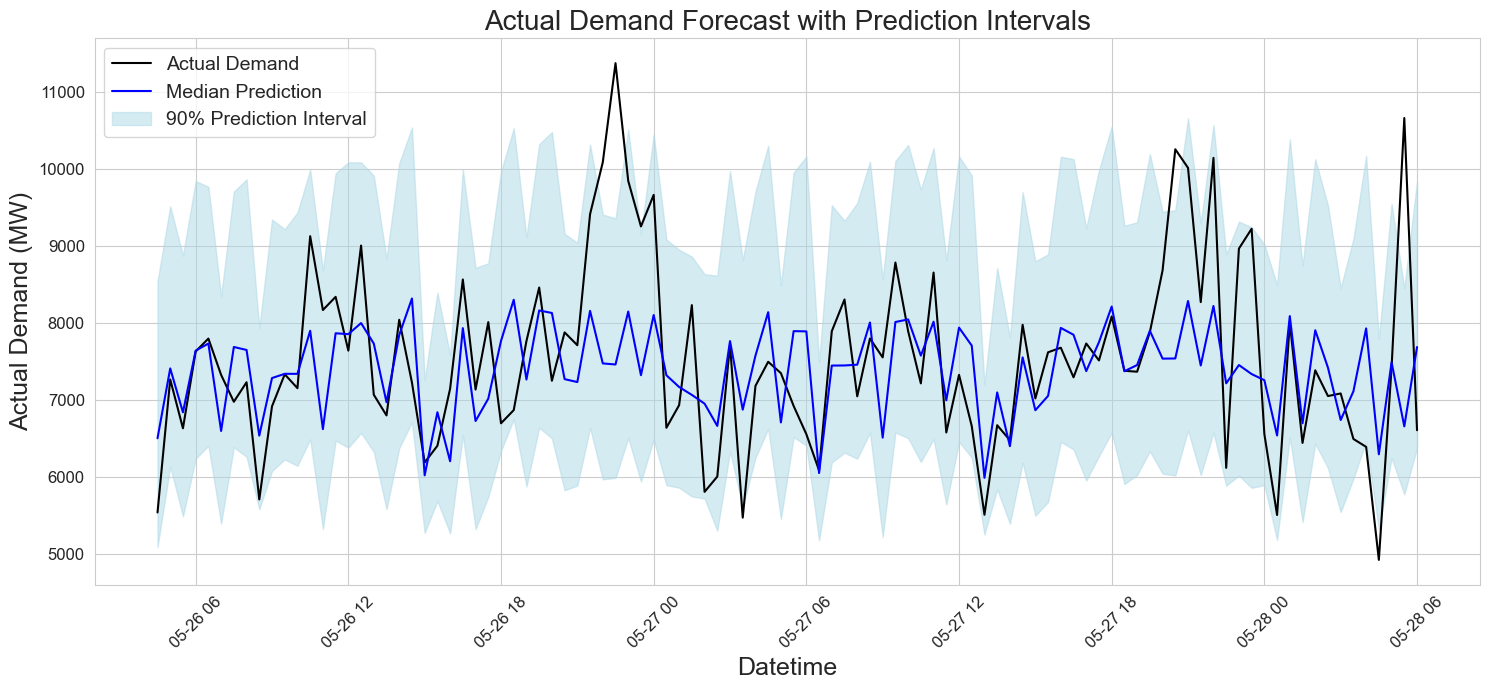

In [45]:
# Selecting a subset for visualization (first 100 records)
subset = merged_df.iloc[split_index:split_index+100]

plt.figure(figsize=(15,7))
plt.plot(subset['mpe_datetime'].iloc[:100], y_test.iloc[:100], label='Actual Demand', color='black')
plt.plot(subset['mpe_datetime'].iloc[:100], prediction_intervals['Median'].iloc[:100], label='Median Prediction', color='blue')
plt.fill_between(
    subset['mpe_datetime'].iloc[:100],
    prediction_intervals['Lower'].iloc[:100],
    prediction_intervals['Upper'].iloc[:100],
    color='lightblue', alpha=0.5, label='90% Prediction Interval'
)
plt.xlabel('Datetime', fontsize= 18)
plt.ylabel('Actual Demand (MW)', fontsize=18)
plt.title('Actual Demand Forecast with Prediction Intervals', fontsize=20)
plt.legend(fontsize=14)
plt.xticks(rotation=45, fontsize = 12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('Actual_Demand_Forecast_with_Prediction_Intervals', dpi=300)
plt.show()

### 7. Conclusion
The pipeline developed for electricity demand forecasting, incorporating PV generation and weather data, produced meaningful insights and robust models. Here's a summary of the results:

#### Baseline and Advanced Model Performance:
* The Simple Linear Regression model served as a baseline, yielding an MAE of 790.02 and RMSE of 1021.03, with an R2R2 of 0.2007. While offering a           straightforward approach, this model struggled to capture the complexity in the data.
* The XGBoost model significantly improved performance with an MAE of 479.99, RMSE of 612.31, and R2R2 of 0.7125, demonstrating that more sophisticated machine learning methods, particularly those capable of capturing non-linear relationships, are better suited to this type of forecasting problem.

#### Uncertainty Quantification:
* The Quantile Regression model, providing a 90.09% coverage of the forecast intervals, effectively captured the range of possible outcomes, offering valuable insights into uncertainty.
* The coefficients for key variables, including PV generation (negative impact), temperature (negative impact), hour of day, and day of week, showed consistent statistical significance across quantiles (0.05, 0.5, and 0.95). These results indicate that PV generation helps reduce the actual demand, while temperature has a more nuanced and varying effect across the demand spectrum.